### Convolutional Neural Network

A specialised type of neural network model designed for working with two-dimensional image data.

Central to the neural network is the `convolutional layer`.

### Sections <a class="anchor" id="sections"></a>
- [1. Getting Started](#section1)
-  [2. Build A DataFrame](#section2)
    - [2.1 Retrieve image filepaths](#section2.1)
    - [2.2 Retrieve image labels](#section2.2)
    - [2.3 Create a panda series](#section2.3)
    - [2.4 Create DataFrame](#section2.4)
- [3. Train, test split](#section3)
- [4. Load image data](#section4)
    - [4.1 Image data augmentation](#section4.1)
    - [4.2 Image flow](#section4.2)
- [5. Training the model](#section5)
    - [5.1 Input layer](#section5.1)
    - [5.2 Convolutional layer](#section5.2)
    - [5.3 Pooling layer](#section5.3)
    - [5.4 Output Tensor](#section5.4)
    - [5.5 Flatten output](#section5.5)
    - [5.6 Global average pooling](#section5.6)
    - [5.7 Dense layer](#section5.7)     
-  [6. Create model](#section6)
    -  [6.1 Compile model](#section6.1)
    -  [6.2 Fit model](#section6.2)
-  [7. Evaluate results](#section7)
    -  [7.1 Confusion matrix](#section7.1)
    -  [7.2 Classification report](#section7.2)

### 1. Getting Started <a class="anchor" id="section1"></a>

`os.listdir()`

In [29]:
import numpy as np
import pandas as pd

from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

%config InlineBackend.figure_format = 'retina'

# Disables unnecessary tensorflow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
# Save current working directory to 'cwd'
cwd = os.getcwd()
print(cwd)

# Returns a list containing the names of all entries in the directory given by path
files = os.listdir(cwd)
print(files)

/Users/sam/Desktop/ttt/imageClassification
['.DS_Store', 'images', '.ipynb_checkpoints', 'imageClassificationProject.ipynb']


### 2. Build a DataFrame <a class="anchor" id="section2"></a>

`pathlib.PosixPath`

In [3]:
# Define image directory / folder path
imageDirectory = Path('images')
print(type(imageDirectory))

<class 'pathlib.PosixPath'>


#### 2.1 Retrieve image filepaths <a class="anchor" id="section2.1"></a>
`.glob()`

In [4]:
# Returns an array / list containing all filenames in image directory / folder ending '.png'
filepaths = list(imageDirectory.glob('**/*.png'))

# Check the number of image filepaths
print(len(filepaths),'\n')

# View a filepath
print(filepaths[1])

999 

images/cat/374.png


#### 2.2 Retrieve image labels <a class="anchor" id="section2.2"></a>

`os.path.split()` `.map()`

In [5]:
# Filepath example (how do we extract the label?)
filepathExample = 'folderName/labelName/example.png'

# Using os.path.split()
print(os.path.split(filepathExample))

# Split this further
print(os.path.split(os.path.split(filepathExample)[0]))

# Now the label can be isolated (this is how we extract the label)
isolatedLabel = os.path.split(os.path.split(filepathExample)[0])[1]
print(isolatedLabel)

('folderName/labelName', 'example.png')
('folderName', 'labelName')
labelName


In [6]:
# We can now map a lambda function with the formula used above to our list of image filepaths
labels = list(map(lambda x : os.path.split(os.path.split(x)[0])[1], filepaths))

# Check the number of labels
print(len(labels),'\n')

# View a label
print(labels[1])

999 

cat


#### 2.3 Create a pandas series <a class="anchor" id="section2.3"></a>

`pandas.Series`

note: `pathlib.PosixPath` objects need to be converted to string dtype before being converted to Series

In [7]:
# Returns a one-dimensional ndarray with axis labels
filepaths=pd.Series(filepaths, name='Filepath').astype(str)

# Number of unique values
print(filepaths.nunique(),'\n')

# Returns a one-dimensional ndarray with axis labels
labels=pd.Series(labels, name='Label').astype(str)

# Number of unique values
print(labels.nunique(),'\n')

# Print the unqiue values
print(labels.unique(),'\n')

# Print the number count for each unique value
print(labels.value_counts())

999 

2 

['cat' 'dog'] 

dog    500
cat    499
Name: Label, dtype: int64


#### 2.4 Create DataFrame <a class="anchor" id="section2.4"></a>
`pandas.concat`

In [8]:
dataframe = pd.concat([filepaths, labels], axis='columns')
display(dataframe.head(), dataframe.tail())

,Filepath,Label
0,images/cat/348.png,cat
1,images/cat/374.png,cat
2,images/cat/360.png,cat
3,images/cat/t1.png,cat
4,images/cat/t16.png,cat


,Filepath,Label
994,images/dog/d64.png,dog
995,images/dog/d70.png,dog
996,images/dog/d235.png,dog
997,images/dog/d58.png,dog
998,images/dog/d209.png,dog


### 3. Train, test split <a class="anchor" id="section3"></a>
`sklearn.model_selection.train_test_split`

In [9]:
# Splits arrays / matrices into random train & test subsets
dfTrain, dfTest = train_test_split(dataframe, train_size=0.7, shuffle=True, random_state=2)
display(dfTrain.head(), dfTest.head())

,Filepath,Label
90,images/cat/173.png,cat
305,images/cat/t53.png,cat
126,images/cat/277.png,cat
962,images/dog/d236.png,dog
163,images/cat/t88.png,cat


,Filepath,Label
37,images/cat/74.png,cat
726,images/dog/d128.png,dog
846,images/dog/d243.png,dog
295,images/cat/286.png,cat
924,images/dog/g28.png,dog


### 4. Load image data <a class="anchor" id="section4"></a>

#### 4.1 Image data augmentation <a class="anchor" id="section4.1"></a>
`tf.keras.preprocessing.image.ImageDataGenerator`

In [10]:
# Define train generator that pulls training images
# - generates batches of tensor image data, performs training, & recycles memory
trainGenerator = tf.keras.preprocessing.image.ImageDataGenerator(
                 rescale = 1/255, 
                 horizontal_flip = True, 
                 width_shift_range = 0.2, 
                 height_shift_range = 0.2,
                 validation_split = 0.2) 

# Defines test generator that pulls test images
# - generates batches of tensor image data, performs training, & recycles memory
testGenerator = tf.keras.preprocessing.image.ImageDataGenerator(
                 rescale = 1/255)

#### 4.2 Image Flow <a class="anchor" id="section4.2"></a>
`flow_from_dataframe()`

In [11]:
# Training the images
# - specifies how the images will be loaded
trainImages = trainGenerator.flow_from_dataframe(
              dataframe = dfTrain, # dataframe to flow through
              x_col = 'Filepath',
              y_col = 'Label',
              target_size = (224,224), 
              color_mode = 'rgb',
              class_mode = 'binary',
              batch_size = 32,
              shuffle = True, # True when training
              seed = 42,
              subset='training')

# Validating the images
# - specifies how the images will be loaded
validateImages = trainGenerator.flow_from_dataframe(
             dataframe = dfTrain,
             x_col = 'Filepath',
             y_col = 'Label',
             target_size = (224,224),
             color_mode = 'rgb',
             class_mode = 'binary',
             batch_size = 32,
             shuffle = True, # True when training
             seed = 42,
             subset='validation')

# Testing the images
# - specifies how the images will be loaded
testImages = testGenerator.flow_from_dataframe(
             dataframe = dfTest,
             x_col = 'Filepath',
             y_col = 'Label',
             target_size = (224,224),
             color_mode = 'rgb',
             class_mode = 'binary',
             batch_size = 32,
             shuffle = False) # False when evaluating 

Found 560 validated image filenames belonging to 2 classes.
Found 139 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


### 5. Training<a class="anchor" id="section5"></a>

#### 5.1 Input layer <a class="anchor" id="section5.1"></a>
`tf.keras.Input` 

note: In keras, the input layer itself is not a layer, but a Tensor (object that flows between layers are Tensors)

In [12]:
# Instantiates a keras tensor 
inputLayer = tf.keras.Input(shape=(224, 224, 3)) # images are 224x224 pixels in RGB (3 channels)
display(inputLayer)

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

#### 5.2 Convolutional Layer<a class="anchor" id="section5.2"></a>
`tf.keras.layers.Conv2D` 

In [13]:
# 2D convolution layer (e.g. spatial convolution over images)
# - the covolutional layer slides a filter/kernal/window across an input image
# - as the convolution window slides across the input image
# - it sends a new value to a 2D array, resulting in a 2D feature
x = tf.keras.layers.Conv2D(
                           filters=16, # how many times window slides across an input image
                           kernel_size=(3, 3), 
                           activation='relu')(inputLayer) 
display(x)

<KerasTensor: shape=(None, 222, 222, 16) dtype=float32 (created by layer 'conv2d')>

#### 5.3 Pooling layer<a class="anchor" id="section5.3"></a>
`tf.keras.layers.MaxPool2D` 

In [14]:
# MaxPool layer
# - maxpool layer reduces the dimensionality of the Tensor
# - it sits between convolutional layers & slides a window across the input image
# - reducing its dimensionality, enabling the subsequent layer to look at high level features
# - that is, the first  layer will view all the pixels of the original image before it is maxpooled
# - then the second convolution layer will be presented with only the most important pixels
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
display(x)

# 2D convolution layer II
x = tf.keras.layers.Conv2D(
                           filters=32, 
                           kernel_size=(3, 3), 
                           activation='relu')(x)

# MaxPool layer II
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)

<KerasTensor: shape=(None, 111, 111, 16) dtype=float32 (created by layer 'max_pooling2d')>

#### 5.4 Output Tensor<a class="anchor" id="section5.4"></a>

In [15]:
# Output Tensor
# - Tensor shape is (54 x 54 x 32)
# - that is, there are now 32 features assumed useful for making classifications
# - however, the output tensor is in 3D form & needs to be compressed down to one dimension
display(x)

<KerasTensor: shape=(None, 54, 54, 32) dtype=float32 (created by layer 'max_pooling2d_1')>

#### 5.5 Flatten output<a class="anchor" id="section5.5"></a>
`tf.keras.layers.Flatten` 

In [16]:
# Flatten the output by taking each row & concatenating them together to create one long vector
# - essentially, this will multiply 54 x 54 x 32
# - however, this will result in 93,000+ features (likely to include mostly redundent information)
# - thus, we will use an alternative method 'GlobalAveragePooling2D'
outputFlattened=tf.keras.layers.Flatten()(x)
display(outputFlattened)

<KerasTensor: shape=(None, 93312) dtype=float32 (created by layer 'flatten')>

#### 5.6 Global average pooling<a class="anchor" id="section5.6"></a>
`tf.keras.layers.GlobalAveragePooling2D`

In [17]:
# Instead of flattening the output, this will average over the first 2 dimensions (54 x 54)
# - this will leave 32 values
# - the goal here is for these 32 features to represent something meaningful about the input image
# - for example, a key physical difference between cats & dogs (i.e. sharp retractable claws of a cat)
# - the goal is to extract information rich features
x = tf.keras.layers.GlobalAveragePooling2D()(x)
display(x)

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'global_average_pooling2d')>

#### 5.7 Dense Layer<a class="anchor" id="section5.7"></a>
`tf.keras.layers.Dense` 

In [18]:
# Returns a dictionary containing the mapping from class names to class indices
# - 1 is the positive class
print(trainImages.class_indices)

{'cat': 0, 'dog': 1}


In [19]:
# Add dense layer to the CNN
# - units represent the number of neurons in each layer of the NN architecture
x = tf.keras.layers.Dense(
    units=128, # dimensionality of the output space
    activation='relu')(x)

# Add a second dense layer to the CNN
x = tf.keras.layers.Dense(units=128, activation='relu')(x)

# Output also a dense layer
# - only outputs one value, with a sigmoid activation since this is a binary classification task (cat or dog)
# - the output here is the probability of the image containing a dog as it is the positive class
outputLayer = tf.keras.layers.Dense(1, activation='sigmoid')(x)
display(outputLayer)

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

### 6. Create model <a class="anchor" id="section6"></a>
`tf.keras.Model`

In [20]:
# Display the input & output layers of the CNN
display(inputLayer, outputLayer)

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [21]:
# Groups these layers into an object with training and inference features
model = tf.keras.Model(inputs=inputLayer, outputs=outputLayer)
print(type(model))

<class 'keras.engine.functional.Functional'>


#### 6.1 Compile model <a class="anchor" id="section6.1"></a>
`.compile()`

In [22]:
# Configures the model for training
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

print(type(model))

<class 'keras.engine.functional.Functional'>


#### 6.2 Fit Model <a class="anchor" id="section6.2"></a>
`.fit()` `keras.callbacks.Callback` `tf.keras.callbacks.EarlyStopping()` `tf.keras.callbacks.ReduceLROnPlateau`

In [23]:
# Trains the model for a fixed number of epochs (i.e. iterations on a dataset)
history = model.fit(x = trainImages,
                    validation_data = validateImages,
                    epochs = 100,
                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                 patience=5,restore_best_weights=True),
                                 tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                 patience=3)]
                    )

Epoch 1/100
18/18 [==============================] - 28s 1s/step - loss: 0.6937 - accuracy: 0.5000 - val_loss: 0.6925 - val_accuracy: 0.4892
Epoch 2/100
18/18 [==============================] - 26s 1s/step - loss: 0.6916 - accuracy: 0.5214 - val_loss: 0.6911 - val_accuracy: 0.5036
Epoch 3/100
18/18 [==============================] - 22s 1s/step - loss: 0.6861 - accuracy: 0.5143 - val_loss: 0.6873 - val_accuracy: 0.5755
Epoch 4/100
18/18 [==============================] - 26s 1s/step - loss: 0.6769 - accuracy: 0.5786 - val_loss: 0.6862 - val_accuracy: 0.5180
Epoch 5/100
18/18 [==============================] - 29s 2s/step - loss: 0.6557 - accuracy: 0.6411 - val_loss: 0.6821 - val_accuracy: 0.5468
Epoch 6/100
18/18 [==============================] - 23s 1s/step - loss: 0.6448 - accuracy: 0.6411 - val_loss: 0.6916 - val_accuracy: 0.5683
Epoch 7/100
18/18 [==============================] - 38s 2s/step - loss: 0.6491 - accuracy: 0.6411 - val_loss: 0.6922 - val_accuracy: 0.5612
Epoch 8/100
1

### 7. Evaluate Results <a class="anchor" id="section7"></a>
`model.evaluate`

In [24]:
# Returns the loss value & metrics values for the model in test mode
results = model.evaluate(x=testImages, verbose=0)
print(results)
print('Test Loss: {:.5f}'.format(results[0]))
print('Test Accuracy: {:.2f}%'.format(results[1] * 100))

[0.6757357716560364, 0.6100000143051147]
Test Loss: 0.67574
Test Accuracy: 61.00%


#### 7.1 Confusion Matrix <a class="anchor" id="section7.1"></a>
`model.predict()` `confusion_matrix()`

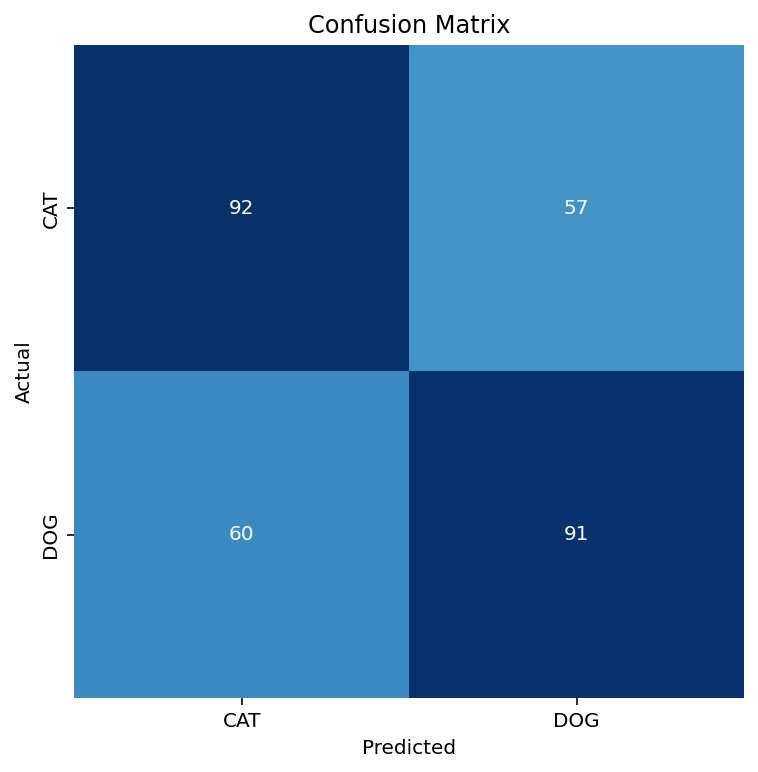

In [31]:
# Generates output predictions for the input samples
# - classification threshold is always 0.5 in a binary classification task
# - if the output predictions are >= 0.5, the model will classify the image as being a dog (i.e. [1])
predictions = (model.predict(testImages) >= 0.5).astype(np.int)

# Performance measurement for machine learning classification
confusionMatrix = confusion_matrix(y_true = testImages.labels,
                                   y_pred = predictions,
                                   labels=[0, 1])

# Plot confusion matrix  
plt.figure(figsize=(6, 6))
sns.heatmap(confusionMatrix, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=['CAT', 'DOG'])
plt.yticks(ticks=[0.5, 1.5], labels=['CAT', 'DOG'])
plt.xlabel('Predicted', loc='center')
plt.ylabel('Actual', loc='center')
plt.title('Confusion Matrix')
plt.show()

#### 7.2 Classification Report <a class="anchor" id="section7.2"></a>
`sklearn.metrics.classification_report`

In [26]:
# Builds a text report showing the main classification metrics
clr = classification_report(testImages.labels, predictions, labels=[0, 1], target_names=["CAT", "DOG"])
print(clr)

              precision    recall  f1-score   support

         CAT       0.61      0.62      0.61       149
         DOG       0.61      0.60      0.61       151

    accuracy                           0.61       300
   macro avg       0.61      0.61      0.61       300
weighted avg       0.61      0.61      0.61       300



[Click this link to return to the top of the page](#sections)